In [2]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')

# Hands-on Activity 14.5: Automatic relevance determination

## Objectives

+ To demonstrate how automatic relevance determination can be used to select which features to keep.

Get some data first:

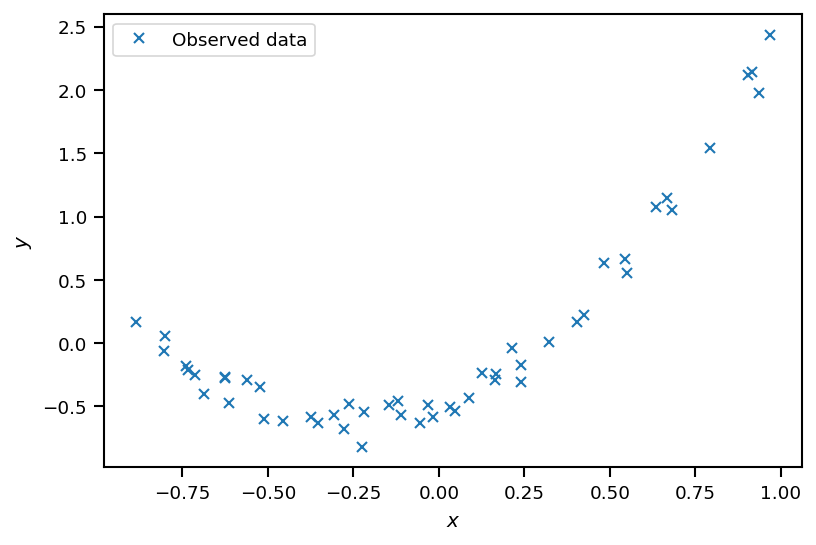

In [101]:
# How many observations we have
num_obs = 50
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 1.0
w2_true = 2.0
sigma_true = 0.1
y = w0_true + w1_true * x + w2_true * x ** 2 + sigma_true * np.random.randn(num_obs)
# Let's plot the data
fig, ax = plt.subplots(dpi=150)
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

Let's also copy paste the code for creating design matrices for the three generalized linear models we have considered so far:

In [102]:
def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """
    Fourier expansion with ``num_terms`` cosines and sines.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(1, int(num_terms / 2)):
        cols.append(np.cos(2 * i * np.pi / L * x))
        cols.append(np.sin(2 * i * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

We are not going to implement the evidence approximation from scratch. Instead we are going to use the implementation in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge):

We are not going to implement the automatic relevance determination from scratch. Instead we are going to use the implementation in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html#sklearn.linear_model.ARDRegression).
Here is how you do it:

In [103]:
# Load the Bayesian linear regression class:
from sklearn.linear_model import ARDRegression
# Select polynomial degree and get design matrix
degree = 5
# Build the design matrix
Phi = get_polynomial_design_matrix(x[:, None], degree)
# You don't have to normalize
model = ARDRegression(normalize=True).fit(Phi, y)
# There is a bug in scikit-learn
model.X_offset_ = np.mean(Phi, axis=0)
model.X_scale_ = np.std(Phi, axis=0)
model.X_scale_[model.X_scale_ <= 0] = 1.0
model.X_scale_

array([1.        , 0.52754531, 0.27285685, 0.31729219, 0.22483134,
       0.2381481 ])

In [104]:
# Sklearn optimizes the precision of the noise which is the inverse of the variance.
# It calls it alpha_.
sigma = np.sqrt(1.0 / model.alpha_)
print('sigma = {0:1.2f}'.format(sigma))

sigma = 0.10


[1.00000000e+00 3.79208396e+00 3.82468513e+00 2.00189023e-02
 3.46437172e-02 3.74704109e-03]


''

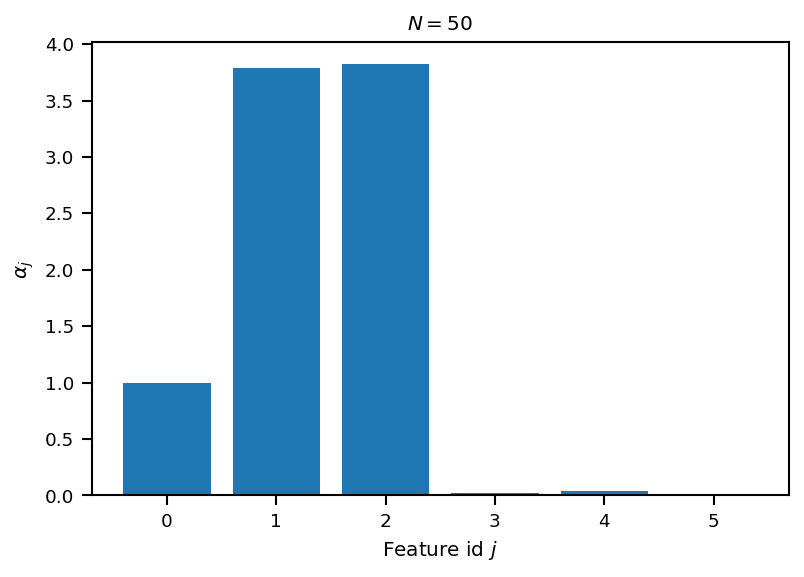

In [105]:
# Sklearn optimizes the inverse of our alpha (the variance of the weights), which
# it calls lambda_.
alpha = np.sqrt(1.0 / model.lambda_)
print(alpha)
fig, ax = plt.subplots(dpi=150)
ax.bar(np.arange(degree+1), alpha)
ax.set_xlabel('Feature id $j$')
ax.set_ylabel(r'$\alpha_j$')
ax.set_title('$N={0:d}$'.format(num_obs))
;

In [106]:
# The posterior mean of the weights is here (this is for the normalized data, however)
m_norm = model.coef_
print(m_norm.shape)

(6,)


In [107]:
# The posterior covariance matrix for the weights is here (also for the normalized data)
S_norm = model.sigma_
print(S_norm.shape)

(5, 5)


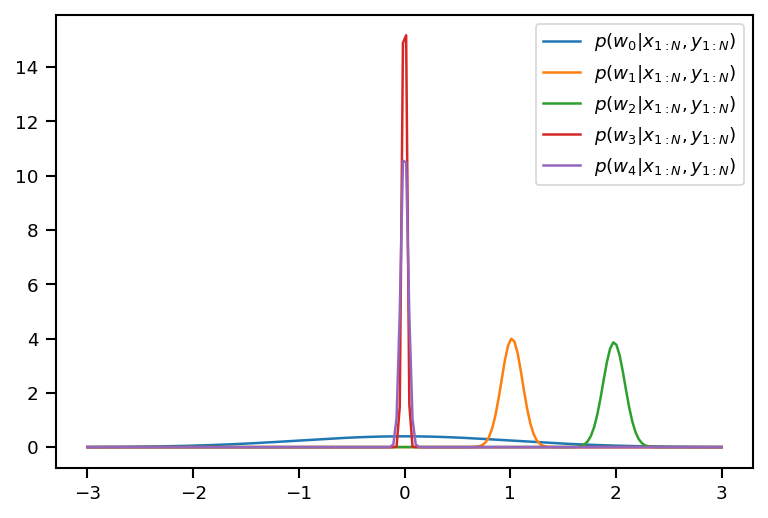

In [108]:
import scipy.stats as st
# plot the posterior of all the weights
ww = np.linspace(-3.0, 3.0, 200)
fig, ax = plt.subplots(dpi=150)
for j in range(S_norm.shape[0]):
    wj_post = st.norm(loc=m_norm[j], scale=np.sqrt(S_norm[j, j]))
    ax.plot(ww, wj_post.pdf(ww), label=r'$p(w_{{{0:d}}}|x_{{1:N}}, y_{{1:N}})$'.format(j))
plt.legend(loc='best')

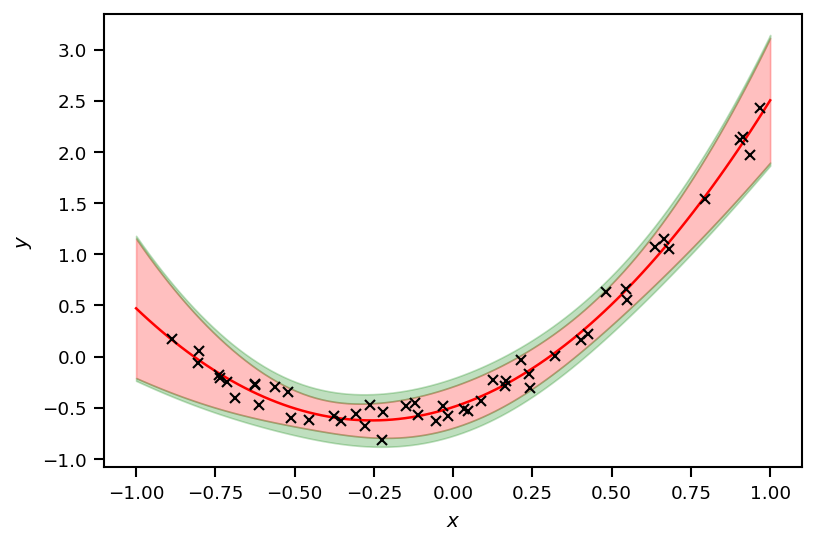

In [109]:
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy_mean, yy_measured_std = model.predict(Phi_xx, return_std=True)
yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
fig, ax = plt.subplots(dpi=150)
ax.plot(xx, yy_mean, 'r')
# Epistemic lower bound
sigma2 = 0.1 ** 2
yy_le = yy_mean - 2.0 * yy_std
# Epistemic upper bound
yy_ue = yy_mean + 2.0 * yy_std
# Epistemic + aleatory lower bound
yy_lae = yy_mean - 2.0 * yy_measured_std
# Episemic + aleatory upper bound
yy_uae = yy_mean + 2.0 * yy_measured_std
ax.fill_between(xx, yy_le, yy_ue, color='red', alpha=0.25)
ax.fill_between(xx, yy_lae, yy_le, color='green', alpha=0.25)
ax.fill_between(xx, yy_ue, yy_uae, color='green', alpha=0.25)
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# overlay the true 
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

What if you wanted to get the samples from the posterior?
You would have to do a little bit of manual work to translate the posterior weights and their variance back to the original values...

In [ ]:
# Do later

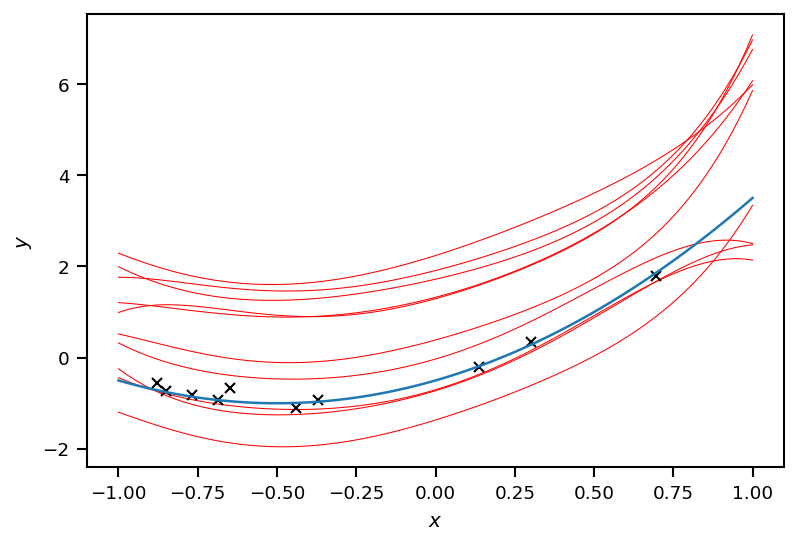

In [25]:
w_post = 
# Posterior samples
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
for _ in range(10):
    w_sample = w_post.rvs()
    yy_sample = np.dot(Phi_xx, w_sample)
    ax.plot(xx, yy_sample, 'r', lw=0.5)
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# overlay the true 
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

ValueError: too many values to unpack (expected 2)

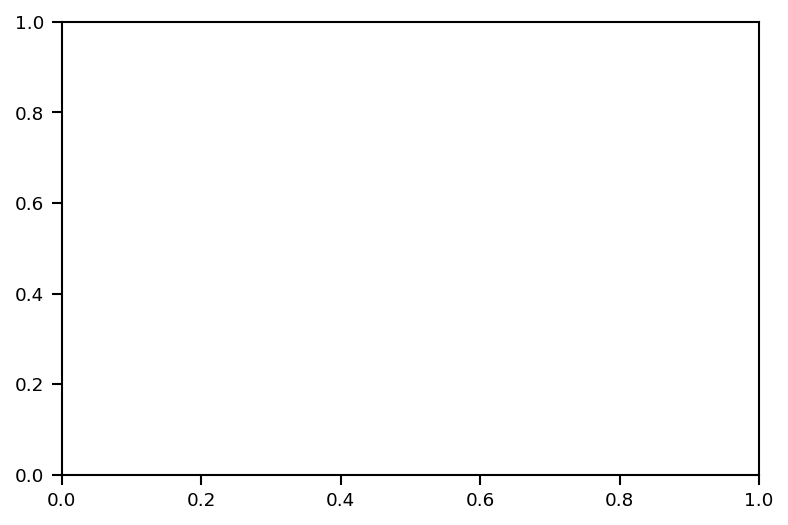

In [26]:
# Posterior samples
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
#yy_mean = np.dot(Phi_xx, m)
#yy_var = np.einsum('ij,jk,ik->i', Phi_xx, S, Phi_xx)
yy_mean, yy_var = model.predict(Phi_xx)
sigma2 = 0.1 ** 2
yy_measured_var = yy_var + sigma2
yy_std = np.sqrt(yy_var)
yy_measured_std = np.sqrt(yy_measured_var)
# Epistemic lower bound
yy_le = yy_mean - 2.0 * yy_std
# Epistemic upper bound
yy_ue = yy_mean + 2.0 * yy_std
# Epistemic + aleatory lower bound
yy_lae = yy_mean - 2.0 * yy_measured_std
# Episemic + aleatory upper bound
yy_uae = yy_mean + 2.0 * yy_measured_std
ax.plot(xx, yy_mean, 'r')
ax.fill_between(xx, yy_le, yy_ue, color='red', alpha=0.25)
ax.fill_between(xx, yy_lae, yy_le, color='green', alpha=0.25)
ax.fill_between(xx, yy_ue, yy_uae, color='green', alpha=0.25)
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# overlay the true 
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');